In [37]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tool.darknet2pytorch import Darknet
from tool.utils import *
from tool.torch_utils import *
import torch
from tqdm import tqdm  # Import tqdm for progress bar
import argparse

cfgfile = 'yolo-fish-2.cfg'
weightfile = 'merge_yolo-fish-2.weights'
csv_file = 'data/Localization.csv'
image_folder = 'data/images'
mask_folder = 'data/masks'
miss = 'mismatch_ids.txt'

In [38]:
m = Darknet(cfgfile)
m.load_weights(weightfile)
m.cuda()

def detect_fish_in_image(img, m, savename):
    """
    Function to detect fish in a given image using YOLO model.
    Returns the number of fish detected.
    """


    sized = cv2.resize(img, (m.width, m.height))
    sized = cv2.cvtColor(sized, cv2.COLOR_BGR2RGB)
        

    boxes = do_detect(m, sized, 0.4, 0.4, True)
    
    # Assuming that each box is a fish detection
    num_fish_detected = len(boxes[0])  # Each box is a fish detection
    plot_boxes_cv2(img, boxes[0], savename=savename, class_names=['fish'])

    return num_fish_detected

-----------------------------------
           Preprocess : 0.030813
      Model Inference : 0.400419
-----------------------------------
-----------------------------------
       max and argmax : 0.001997
                  nms : 0.000000
Post processing total : 0.001997
-----------------------------------
fish: 0.999843
fish: 0.993636
fish: 0.992614
fish: 0.991362
fish: 0.754339
fish: 0.559370
save plot results to res.jpg
Number of contours found: 7


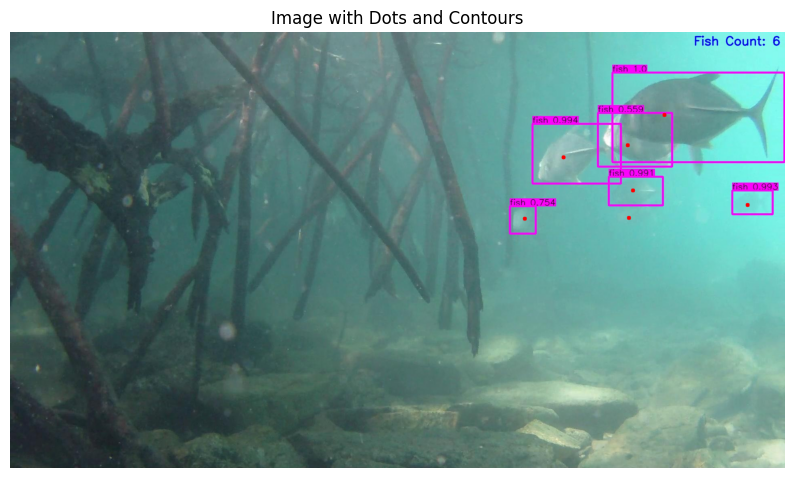

In [41]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt


# Function to read mismatch IDs from a file
def read_mismatch_ids(file_path):
    with open(file_path, 'r') as file:
        lines = file.read().splitlines()
    mismatch_ids = [line.split()[0] for line in lines]  # Assuming IDs are the first element in each line
    return mismatch_ids


# Function to filter the DataFrame based on mismatch IDs
def filter_dataframe(df, mismatch_ids):
    return df[df['ID'].isin(mismatch_ids)]


# Function to detect fish and save processed image
def detect_and_save_fish_image(img, model, save_path):
    # Assuming detect_fish_in_image is a pre-defined function that detects fish and saves the image
    detect_fish_in_image(img, model, save_path)


# Function to detect contours in the mask image
def detect_contours(mask_path):
    mask = cv2.imread(mask_path)
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours


# Function to draw red circles on the image at contour locations
def draw_contours_on_image(img, contours):
    img_with_dots = img.copy()
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius) + 5  # Make the circle slightly bigger
        cv2.circle(img_with_dots, center, radius, (0, 0, 255), -1)  # Draw a filled red circle
    return img_with_dots


# Function to display images side by side (original with dots and processed)
def display_images_with_comparison(original_img, processed_img, img_id):
    plt.figure(figsize=(20, 15))

    # Plot the original image with red dots
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original with dots - ID: {img_id}")
    plt.axis('off')

    # Plot the processed image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Processed - ID: {img_id}")
    plt.axis('off')

    # Show the side-by-side comparison
    plt.show()


# Main function to process and visualize images based on mismatch IDs
def process_images(csv_file, miss_file, image_folder, mask_folder, model, n_images=10):
    # Read mismatch IDs
    mismatch_ids = read_mismatch_ids(miss_file)
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Filter DataFrame for mismatch IDs
    filtered_df = filter_dataframe(df, mismatch_ids)
    
    # Select random images from filtered DataFrame
    random_images = filtered_df.sample(n=n_images)
    
    n = 0
    for idx, row in random_images.iterrows():
        img_id = row['ID']
        img_path = os.path.join(image_folder, img_id + '.jpg')
        
        # Load original image
        img = cv2.imread(img_path)
        
        # Detect fish and save to a file
        save_name = f'res/{n}.jpg'
        detect_and_save_fish_image(img, model, save_name)

        # Load mask and detect contours
        mask_path = os.path.join(mask_folder, img_id + '.png')
        contours = detect_contours(mask_path)
        print(f"Number of contours found: {len(contours)}")
        
        # Draw contours on original image
        img_with_dots = draw_contours_on_image(img, contours)
        
        # Load the processed image
        processed_img = cv2.imread(save_name)
        
        # Display side-by-side comparison of original and processed image
        display_images_with_comparison(img_with_dots, processed_img, img_id)

        n += 1

# Load the original image
img = cv2.imread('data/images/valid/7117_Caranx_sexfasciatus_juvenile_f000170.jpg')

# Detect fish and save to a file
detect_fish_in_image(img, m, 'res.jpg')

# Load mask and detect contours
mask_path = os.path.join(mask_folder, 'valid/7117_Caranx_sexfasciatus_juvenile_f000170' + '.png')
contours = detect_contours(mask_path)
print(f"Number of contours found: {len(contours)}")

# Draw contours and dots on the same image

img_with_dots_and_contours = draw_contours_on_image(cv2.imread("res.jpg"), contours)


# Display the image with dots and contours
plt.figure(figsize=(10, 7))
plt.imshow(cv2.cvtColor(img_with_dots_and_contours, cv2.COLOR_BGR2RGB))
plt.title('Image with Dots and Contours')
plt.axis('off')
plt.show()




In [40]:
# Example usage:
process_images(csv_file=csv_file, 
               miss_file=miss, 
               image_folder=image_folder, 
               mask_folder=mask_folder, 
               model=m, 
               n_images=10)

ValueError: a must be greater than 0 unless no samples are taken